# 属性数据操作

## 先决条件

In [1]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 6
pd.options.display.max_columns = 6
pd.options.display.max_colwidth = 35
plt.rcParams['figure.figsize'] = (5, 5)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio

示例数据

In [3]:
#| echo: false
import os
from urllib.request import urlretrieve

data_path = 'data'
if not os.path.exists(data_path):
  os.mkdir(data_path)
  
file_path = 'data/landsat.tif'
url = 'https://github.com/geocompx/geocompy/releases/download/0.1/landsat.tif'
if not os.path.exists(file_path):
  print('Attempting to get the data')
  urlretrieve(url, file_path)

Attempting to get the data


In [4]:
world = gpd.read_file('data/world.gpkg')
src_elev = rasterio.open('data/elev.tif')
src_multi_rast = rasterio.open('data/landsat.tif')

## Introduction

属性数据是与地理（几何）数据相关联的非空间信息。
公共汽车站提供了一个简单的示例：除了名称之外，它的位置通常由纬度和经度坐标（几何数据）表示。
例如，伦敦的 Elephant & Castle / New Kent Road 停靠点的坐标为经度“-0.098”和纬度“51.495”，在@中描述的简单特征表示中可以表示为“POINT (-0.098 51.495)” sec-空间类。
诸如“POINT”特征（使用简单特征术语）的名称属性等属性是本章的主题。

另一个例子是栅格数据中特定网格单元的高程值（属性）。 与矢量数据模型不同，栅格数据模型间接存储网格单元的坐标，这意味着属性和空间信息之间的区别不太明确。
为了说明这一点，请考虑光栅矩阵第 3 行和第 4 列中的像素。
它的空间位置由其在矩阵中的索引定义：从原点在 x 方向（通常在地图上向东和向右）移动四个像元，在 y 方向（通常向南和向下）移动三个像元。
光栅的分辨率定义了标题中指定的每个 x 和 y 步长的距离。
标头是栅格数据集的重要组成部分，它指定像素如何与地理坐标相关（另请参阅@spatial-operations 章）。

本章介绍如何根据属性（例如矢量数据集中的公交车站名称和栅格数据集中的像素高程）来操作地理对象。
对于矢量数据，这意味着子集化和聚合等技术（参见@sec-vector-attribute-subsetting 和@sec-vector-attribute-aggregation）。
@sec-vector-attribute-joining 和@sec-creating-attributes-and-removing-spatial-information 分别演示了如何使用共享 ID 将数据连接到简单要素对象以及如何创建新变量。
这些操作中的每一个都有一个空间等价物：例如，用于使用布尔值`Series` 对`(Geo)DataFrame` 进行子集化的`[` 运算符适用于基于对象的属性和空间关系的子集化对象，这些方法使用诸如 `.相交`； 您还可以使用空间连接连接两个地理数据集中的属性。 这是个好消息：本章培养的技能可以交叉迁移。
@sec-spatial-operations 将此处介绍的方法扩展到空间世界。

在下一节深入探讨各种类型的矢量属性操作之后，@sec-manipulating-raster-objects 介绍了栅格属性数据操作，它演示了如何创建包含连续和分类属性的栅格图层并从其中提取像元值 或更多层（栅格子集）。
@sec-summarizing-raster-objects 提供了“全局”栅格操作的概述，可用于汇总整个栅格数据集。

## 矢量属性操作

如@sec-vector-layers 中所述，矢量图层（`GeoDataFrame`，来自包**geopandas**）基本上是扩展表（来自包**pandas** 的`DataFrame`），不同之处在于矢量图层具有 几何列。
由于 `GeoDataFrame` 扩展了 `DataFrame`，矢量图层也支持包 **pandas** 中所有与表相关的普通操作，如下所示。

### 向量属性子集 {#sec-vector-attribute-subsetting}

**pandas** 支持多个子集接口，但最[推荐](https://stackoverflow.com/questions/38886080/python-pandas-series-why-use-loc) 是：

* `.loc`，它使用 pandas 索引，以及
* `.iloc`，它使用（隐式）numpy 风格的数字索引。

在这两种情况下，该方法后跟方括号和两个索引，以逗号分隔。 每个索引可以包括：

* 一个特定的值，如 `1`
* 一片，如 `0:3`
* 一个 `list`，如 `[0,2,4]`
* `:`——表示“所有”索引

此规则的一个例外是使用列表选择列，如“df[['a','b']]”，而不是“df.loc[:, ['a','b']]”， 从 `df` 中选择列 `'a'` 和 `'b'`。

以下是对世界各国的“GeoDataFrame”进行子集化的几个示例。

按位置子集行，例如前三行：

In [5]:
world.iloc[0:3, :]

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
0,FJ,Fiji,Oceania,...,69.960,8222.253784,MULTIPOLYGON (((-180.00000 -16....
1,TZ,Tanzania,Africa,...,64.163,2402.099404,MULTIPOLYGON (((33.90371 -0.950...
2,EH,Western Sahara,Africa,...,NaN,NaN,MULTIPOLYGON (((-8.66559 27.656...


这相当于：

In [6]:
world.iloc[:3]

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
0,FJ,Fiji,Oceania,...,69.960,8222.253784,MULTIPOLYGON (((-180.00000 -16....
1,TZ,Tanzania,Africa,...,64.163,2402.099404,MULTIPOLYGON (((33.90371 -0.950...
2,EH,Western Sahara,Africa,...,NaN,NaN,MULTIPOLYGON (((-8.66559 27.656...


In [7]:
world.head(3)

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
0,FJ,Fiji,Oceania,...,69.960,8222.253784,MULTIPOLYGON (((-180.00000 -16....
1,TZ,Tanzania,Africa,...,64.163,2402.099404,MULTIPOLYGON (((33.90371 -0.950...
2,EH,Western Sahara,Africa,...,NaN,NaN,MULTIPOLYGON (((-8.66559 27.656...


In [8]:
world.iloc[:, 0:3]

,iso_a2,name_long,continent
0,FJ,Fiji,Oceania
1,TZ,Tanzania,Africa
2,EH,Western Sahara,Africa
...,...,...,...
174,XK,Kosovo,Europe
175,TT,Trinidad and Tobago,North America
176,SS,South Sudan,Africa


按位置子集行和列：

In [9]:
world.iloc[0:3, 0:3]

,iso_a2,name_long,continent
0,FJ,Fiji,Oceania
1,TZ,Tanzania,Africa
2,EH,Western Sahara,Africa


按名称子集列：

In [10]:
world[['name_long', 'geometry']]

,name_long,geometry
0,Fiji,MULTIPOLYGON (((-180.00000 -16....
1,Tanzania,MULTIPOLYGON (((33.90371 -0.950...
2,Western Sahara,MULTIPOLYGON (((-8.66559 27.656...
...,...,...
174,Kosovo,MULTIPOLYGON (((20.59025 41.855...
175,Trinidad and Tobago,MULTIPOLYGON (((-61.68000 10.76...
176,South Sudan,MULTIPOLYGON (((30.83385 3.5091...


给定列之间的“切片”列：

In [11]:
world.loc[:, 'name_long':'pop']

,name_long,continent,region_un,...,type,area_km2,pop
0,Fiji,Oceania,Oceania,...,Sovereign country,19289.970733,885806.0
1,Tanzania,Africa,Africa,...,Sovereign country,932745.792357,52234869.0
2,Western Sahara,Africa,Africa,...,Indeterminate,96270.601041,NaN
...,...,...,...,...,...,...,...
174,Kosovo,Europe,Europe,...,Sovereign country,11230.261672,1821800.0
175,Trinidad and Tobago,North America,Americas,...,Sovereign country,7737.809855,1354493.0
176,South Sudan,Africa,Africa,...,Sovereign country,624909.099086,11530971.0


通过布尔值列表（0 和 1 或 True 和 False）进行子集化：

In [12]:
x = [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0] 
world.iloc[:, x]

,name_long,name_long,iso_a2,...,name_long,iso_a2,iso_a2
0,Fiji,Fiji,FJ,...,Fiji,FJ,FJ
1,Tanzania,Tanzania,TZ,...,Tanzania,TZ,TZ
2,Western Sahara,Western Sahara,EH,...,Western Sahara,EH,EH
...,...,...,...,...,...,...,...
174,Kosovo,Kosovo,XK,...,Kosovo,XK,XK
175,Trinidad and Tobago,Trinidad and Tobago,TT,...,Trinidad and Tobago,TT,TT
176,South Sudan,South Sudan,SS,...,South Sudan,SS,SS


我们可以使用 .drop 方法通过 id 删除特定行，例如，删除第 2、3 和 5 行：

In [13]:
world.drop([2, 3, 5])

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
0,FJ,Fiji,Oceania,...,69.960000,8222.253784,MULTIPOLYGON (((-180.00000 -16....
1,TZ,Tanzania,Africa,...,64.163000,2402.099404,MULTIPOLYGON (((33.90371 -0.950...
4,US,United States,North America,...,78.841463,51921.984639,MULTIPOLYGON (((-171.73166 63.7...
...,...,...,...,...,...,...,...
174,XK,Kosovo,Europe,...,71.097561,8698.291559,MULTIPOLYGON (((20.59025 41.855...
175,TT,Trinidad and Tobago,North America,...,70.426000,31181.821196,MULTIPOLYGON (((-61.68000 10.76...
176,SS,South Sudan,Africa,...,55.817000,1935.879400,MULTIPOLYGON (((30.83385 3.5091...


或者使用 .drop 方法和 axis=1 （即列）删除特定列：

In [14]:
world.drop(['name_long', 'continent'], axis=1)

,iso_a2,region_un,subregion,...,lifeExp,gdpPercap,geometry
0,FJ,Oceania,Melanesia,...,69.960000,8222.253784,MULTIPOLYGON (((-180.00000 -16....
1,TZ,Africa,Eastern Africa,...,64.163000,2402.099404,MULTIPOLYGON (((33.90371 -0.950...
2,EH,Africa,Northern Africa,...,NaN,NaN,MULTIPOLYGON (((-8.66559 27.656...
...,...,...,...,...,...,...,...
174,XK,Europe,Southern Europe,...,71.097561,8698.291559,MULTIPOLYGON (((20.59025 41.855...
175,TT,Americas,Caribbean,...,70.426000,31181.821196,MULTIPOLYGON (((-61.68000 10.76...
176,SS,Africa,Eastern Africa,...,55.817000,1935.879400,MULTIPOLYGON (((30.83385 3.5091...


我们可以使用 .rename 方法重命名列：

In [15]:
world[['name_long', 'pop']].rename(columns={'pop': 'population'})

,name_long,population
0,Fiji,885806.0
1,Tanzania,52234869.0
2,Western Sahara,NaN
...,...,...
174,Kosovo,1821800.0
175,Trinidad and Tobago,1354493.0
176,South Sudan,11530971.0


标准的 **numpy** 比较运算符可用于布尔子集化，如表 @tbl-comparison-operators 所示。

|`符号` | `名字` |
|---|---|
| `==` | 等于 |
| `!=` | 不等于 |
| `>`, `<` | 大于/小于 |
| `>=`, `<=` | 大于/小于或等于 |
| `&`, `|`, `~` | 逻辑运算符：And、Or、Not |

: 返回布尔值的比较运算符 (`True`/`False`)。 {#tbl-比较运算符}

以下示例通过创建一个名为“small_countries”的新“GeoDataFrame”对象演示了用于子集化的逻辑向量，该对象仅包含表面积小于 10,000 km^2^ 的国家：

In [16]:
idx_small = world['area_km2'] < 10000  ## a logical 'Series'
small_countries = world[idx_small]
small_countries

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
45,PR,Puerto Rico,North America,...,79.390122,35066.046376,MULTIPOLYGON (((-66.28243 18.51...
79,PS,Palestine,Asia,...,73.126000,4319.528283,MULTIPOLYGON (((35.39756 31.489...
89,VU,Vanuatu,Oceania,...,71.709000,2892.341604,MULTIPOLYGON (((166.79316 -15.6...
...,...,...,...,...,...,...,...
160,None,Northern Cyprus,Asia,...,NaN,NaN,MULTIPOLYGON (((32.73178 35.140...
161,CY,Cyprus,Asia,...,80.173000,29786.365653,MULTIPOLYGON (((32.73178 35.140...
175,TT,Trinidad and Tobago,North America,...,70.426000,31181.821196,MULTIPOLYGON (((-61.68000 10.76...


中介“idx_small”（代表小国家的索引的缩写）是一个布尔值“Series”，可用于按表面积划分世界上七个最小国家的子集。
省略中间对象的更简洁的命令会生成相同的结果：

In [17]:
small_countries = world[world['area_km2'] < 10000]
small_countries

,iso_a2,name_long,continent,...,lifeExp,gdpPercap,geometry
45,PR,Puerto Rico,North America,...,79.390122,35066.046376,MULTIPOLYGON (((-66.28243 18.51...
79,PS,Palestine,Asia,...,73.126000,4319.528283,MULTIPOLYGON (((35.39756 31.489...
89,VU,Vanuatu,Oceania,...,71.709000,2892.341604,MULTIPOLYGON (((166.79316 -15.6...
...,...,...,...,...,...,...,...
160,None,Northern Cyprus,Asia,...,NaN,NaN,MULTIPOLYGON (((32.73178 35.140...
161,CY,Cyprus,Asia,...,80.173000,29786.365653,MULTIPOLYGON (((32.73178 35.140...
175,TT,Trinidad and Tobago,North America,...,70.426000,31181.821196,MULTIPOLYGON (((-61.68000 10.76...


上面显示的各种方法可以链接起来，用于与多个子集步骤的任意组合，例如：

In [18]:
world[world['continent'] == 'Asia']  \
    .loc[:, ['name_long', 'continent']]  \
    .iloc[0:5, :]

,name_long,continent
5,Kazakhstan,Asia
6,Uzbekistan,Asia
8,Indonesia,Asia
24,Timor-Leste,Asia
76,Israel,Asia


我们还可以组合索引：

In [19]:
idx_small = world['area_km2'] < 10000
idx_asia = world['continent'] == 'Asia'
world.loc[idx_small & idx_asia, ['name_long', 'continent', 'area_km2']]

,name_long,continent,area_km2
79,Palestine,Asia,5037.103826
160,Northern Cyprus,Asia,3786.364506
161,Cyprus,Asia,6207.006191


### 矢量属性聚合 

聚合涉及基于一个或多个*分组变量*（通常是列中的值；地理聚合将在下一章介绍）汇总数据。 这种基于属性的聚合的一个典型示例是根据国家级数据（每个国家一行）计算每个大陆的人数。
“world”数据集包含必要的成分：列“pop”和“continent”，分别是人口和分组变量。 目的是找到每个大陆的国家人口的“sum()”，从而得到更小的数据框。 （由于聚合是数据缩减的一种形式，因此在处理大型数据集时它可能是一个有用的早期步骤）。 这种聚合可以使用 .groupby 和 .sum 的组合来实现：

In [20]:
world_agg1 = world[['continent', 'pop']].groupby('continent').sum()
world_agg1

,pop
continent,
Africa,1.154947e+09
Antarctica,0.000000e+00
Asia,4.311408e+09
...,...
Oceania,3.775783e+07
Seven seas (open ocean),0.000000e+00
South America,4.120608e+08


如果您不喜欢默认使用的科学记数法来显示人口总和，您可以像这样更改浮点值的 Pandas 显示格式：

In [21]:
pd.set_option('display.float_format', '{:.0f}'.format)
world_agg1

,pop
continent,
Africa,1154946633
Antarctica,0
Asia,4311408059
...,...
Oceania,37757833
Seven seas (open ocean),0
South America,412060811


结果是一个（非空间）表，有八行，每个大陆一行，两列报告每个大陆的名称和人口。

如果我们想在聚合结果中包含几何图形，我们可以使用 .dissolve 方法。
这样，除了人口总和之外，我们还可以获得每个大陆的相关几何图形，即所有国家的联合。
请注意，我们使用“by”参数来选择用于分组的列，并使用“aggfunc”参数来选择非几何列的聚合函数：

In [22]:
world_agg2 = world[['continent', 'pop', 'geometry']] \
    .dissolve(by='continent', aggfunc='sum') \
    .reset_index()
world_agg2

,continent,geometry,pop
0,Africa,MULTIPOLYGON (((32.83012 -26.74...,1154946633
1,Antarctica,MULTIPOLYGON (((-66.29003 -80.2...,0
2,Asia,MULTIPOLYGON (((120.29501 -10.2...,4311408059
...,...,...,...
5,Oceania,MULTIPOLYGON (((169.66781 -43.5...,37757833
6,Seven seas (open ocean),"POLYGON ((68.93500 -48.62500, 6...",0
7,South America,MULTIPOLYGON (((-66.95992 -54.8...,412060811


@fig-spatial-aggregation 显示结果：

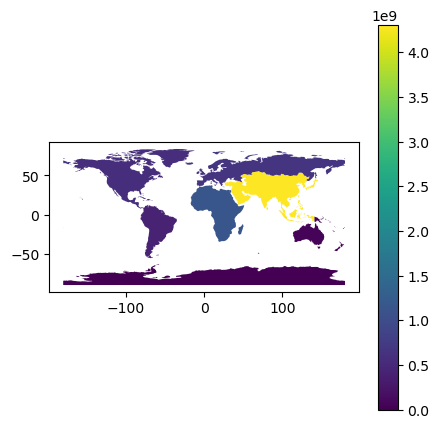

In [23]:
#| label: fig-spatial-aggregation
#| fig-cap: Continents with summed population

world_agg2.plot(column='pop', legend=True);

生成的“world_agg2”对象是一个“GeoDataFrame”，其中包含代表世界各大洲（和公海）的 8 个特征。

.dissolve 中 aggfunc 参数的其他选项 [包括](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html)：

*`'第一'`
*`'最后'`
*`'分钟'`
*`'最大'`
*`'总和'`
*`'平均'`
*`'中位数'`

此外，我们可以传递自定义函数。

作为一个更复杂的例子，下面是我们如何计算每个大陆的总人口、面积和国家数量：

In [24]:
world_agg3 = world.dissolve(
    by='continent', aggfunc={
         "name_long": "count",
         "pop": "sum",
         'area_km2': "sum"
     }).rename(columns={'name_long': 'n'})
world_agg3

,geometry,n,pop,area_km2
continent,,,,
Africa,MULTIPOLYGON (((32.83012 -26.74...,51,1154946633,29946198
Antarctica,MULTIPOLYGON (((-66.29003 -80.2...,1,0,12335956
Asia,MULTIPOLYGON (((120.29501 -10.2...,47,4311408059,31252459
...,...,...,...,...
Oceania,MULTIPOLYGON (((169.66781 -43.5...,7,37757833,8504489
Seven seas (open ocean),"POLYGON ((68.93500 -48.62500, 6...",1,0,11603
South America,MULTIPOLYGON (((-66.95992 -54.8...,13,412060811,17762592


图 @fig-spatial-aggregation-different-functions 可视化了具有三个聚合属性的大陆的结果层 (`world_agg3`)。

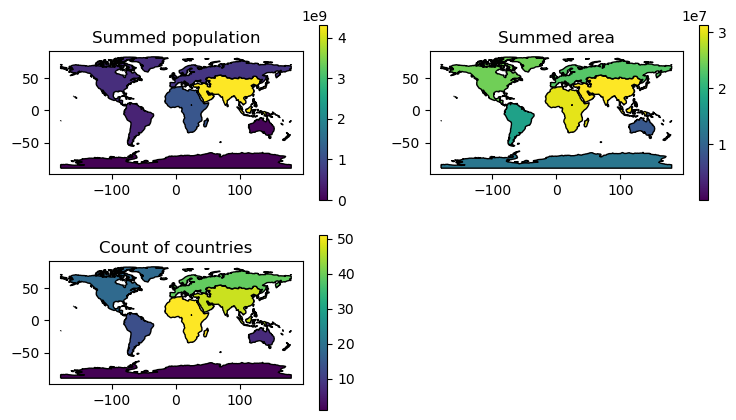

In [25]:
#| label: fig-spatial-aggregation-different-functions
#| fig-cap: 'Continent properties, calculated using spatial aggregation using different functions'

fig, axes = plt.subplots(2, 2, figsize=(9, 5))
world_agg3.plot(column='pop', edgecolor='black', legend=True, ax=axes[0][0])
world_agg3.plot(column='area_km2', edgecolor='black', legend=True, ax=axes[0][1])
world_agg3.plot(column='n', edgecolor='black', legend=True, ax=axes[1][0])
axes[0][0].set_title('Summed population')
axes[0][1].set_title('Summed area')
axes[1][0].set_title('Count of countries')
fig.delaxes(axes[1][1]);

下面继续最后的结果来演示其他表相关的操作。 鉴于“world_agg3”大陆摘要（@fig-spatial-aggregation-different-functions），我们：

* 删除几何列，
*计算每个大陆的人口密度，
* 按大洲包含的国家数量排列大洲，以及
* 只保留 3 个人口最多的大陆。

In [26]:
world_agg4 = world_agg3.drop(columns=['geometry'])
world_agg4['density'] = world_agg4['pop'] / world_agg4['area_km2']
world_agg4 = world_agg4.sort_values(by='n', ascending=False)
world_agg4 = world_agg4.head(3)
world_agg4

,n,pop,area_km2,density
continent,,,,
Africa,51,1154946633,29946198,39
Asia,47,4311408059,31252459,138
Europe,39,669036256,23065219,29


### 矢量属性加入

合并来自不同来源的数据是数据准备中的一项常见任务。 联接通过基于共享的“键”变量组合表来实现这一点。
**pandas** 有一个名为 `pd.merge` 的函数，用于基于公共列加入 `(Geo)DataFrames`。
`pd.merge` 函数遵循数据库语言 SQL 中使用的约定（Grolemund 和 Wickham 2016）。
`pd.merge` 函数对 `DataFrame` 和 `GeoDataFrame` 对象的作用相同。
`pd.merge` 的结果可以是 `DataFrame` 或 `GeoDataFrame` 对象，具体取决于输入。

一种常见的空间数据属性连接类型是将“DataFrames”连接到“GeoDataFrames”。
为实现这一点，我们使用带有 `GeoDataFrame` 作为第一个参数的 `pd.merge`，并从指定为第二个参数的 `DataFrame` 向其添加列。
在以下示例中，我们将咖啡生产数据与“世界”数据集结合起来。
咖啡数据位于从主要咖啡生产国的 CSV 文件中导入的名为“coffee_data”的“DataFrame”中：

In [27]:
coffee_data = pd.read_csv('data/coffee_data.csv')
coffee_data

,name_long,coffee_production_2016,coffee_production_2017
0,Angola,NaN,NaN
1,Bolivia,3,4
2,Brazil,3277,2786
...,...,...,...
44,Zambia,3,NaN
45,Zimbabwe,1,1
46,Others,23,26


它的三列是：

* `name_long` 国家名称
* `coffee_production_2016` 和 `coffee_production_2017` 包含以每年 60 公斤袋为单位的咖啡产量估计值。

保留第一个数据集的左连接基于常见的“name_long”列将“world”与“coffee_data”合并：

In [28]:
world_coffee = pd.merge(world, coffee_data, on='name_long', how='left')
world_coffee

,iso_a2,name_long,continent,...,geometry,coffee_production_2016,coffee_production_2017
0,FJ,Fiji,Oceania,...,MULTIPOLYGON (((-180.00000 -16....,NaN,NaN
1,TZ,Tanzania,Africa,...,MULTIPOLYGON (((33.90371 -0.950...,81,66
2,EH,Western Sahara,Africa,...,MULTIPOLYGON (((-8.66559 27.656...,NaN,NaN
...,...,...,...,...,...,...,...
174,XK,Kosovo,Europe,...,MULTIPOLYGON (((20.59025 41.855...,NaN,NaN
175,TT,Trinidad and Tobago,North America,...,MULTIPOLYGON (((-61.68000 10.76...,NaN,NaN
176,SS,South Sudan,Africa,...,MULTIPOLYGON (((30.83385 3.5091...,NaN,NaN


结果是一个与原始 `world` 对象相同的 `GeoDataFrame` 对象，但有两个关于咖啡生产的新变量（`coffee_production_2016` 和 `coffee_production_2017`）。
这可以绘制成地图，如@fig-join-coffee-production 所示：

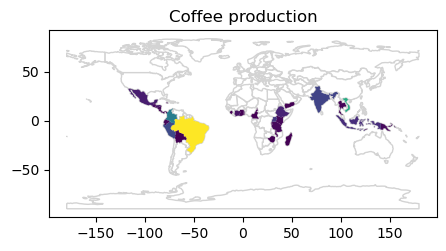

In [29]:
#| label: fig-join-coffee-production
#| fig-cap: 'World coffee production, thousand 60-kg bags by country, in 2017 (source: International Coffee Organization).'

base = world_coffee.plot(color='white', edgecolor='lightgrey')
coffee_map = world_coffee.plot(ax=base, column='coffee_production_2017')
coffee_map.set_title('Coffee production');

要工作，基于属性的连接需要在两个数据集中都有一个“关键变量”（“pd.merge”的“on”参数）。
在上面的示例中，`world_coffee` 和 `world` DataFrames 都包含一个名为 `name_long` 的列。
（默认情况下，`pd.merge` 使用所有具有匹配名称的列。但是，建议明确指定要用于匹配的列的名称，就像我们在上一个示例中所做的那样。）

如果列名不同，您可以使用 `left_on` 和 `right_on` 来指定各自的列。

请注意，结果“world_coffee”与原始数据集“world”具有相同的行数。
虽然 `coffee_data` 中只有 47 行，但 `world_coffee` 中所有 177 个国家/地区的记录都完好无损。 原始数据集中没有匹配项的行被分配了新咖啡生产变量的“np.nan”值。
这是左连接的一个特征（用 `how='left'` 指定），也是我们通常想要做的。

如果我们只想保留关键变量匹配的国家怎么办？
在这种情况下，可以使用内部连接：

In [30]:
pd.merge(world, coffee_data, on='name_long', how='inner')

,iso_a2,name_long,continent,...,geometry,coffee_production_2016,coffee_production_2017
0,TZ,Tanzania,Africa,...,MULTIPOLYGON (((33.90371 -0.950...,81,66
1,PG,Papua New Guinea,Oceania,...,MULTIPOLYGON (((141.00021 -2.60...,114,74
2,ID,Indonesia,Asia,...,MULTIPOLYGON (((104.36999 -1.08...,742,360
...,...,...,...,...,...,...,...
42,ET,Ethiopia,Africa,...,MULTIPOLYGON (((47.78942 8.0030...,215,283
43,UG,Uganda,Africa,...,MULTIPOLYGON (((33.90371 -0.950...,408,443
44,RW,Rwanda,Africa,...,MULTIPOLYGON (((30.41910 -1.134...,36,42


连接两个 (Geo)DataFrame 的另一种方法是恰当地称为“join”函数：

In [31]:
world.join(coffee_data.set_index('name_long'), on='name_long', how='inner')

,iso_a2,name_long,continent,...,geometry,coffee_production_2016,coffee_production_2017
1,TZ,Tanzania,Africa,...,MULTIPOLYGON (((33.90371 -0.950...,81,66
7,PG,Papua New Guinea,Oceania,...,MULTIPOLYGON (((141.00021 -2.60...,114,74
8,ID,Indonesia,Asia,...,MULTIPOLYGON (((104.36999 -1.08...,742,360
...,...,...,...,...,...,...,...
165,ET,Ethiopia,Africa,...,MULTIPOLYGON (((47.78942 8.0030...,215,283
168,UG,Uganda,Africa,...,MULTIPOLYGON (((33.90371 -0.950...,408,443
169,RW,Rwanda,Africa,...,MULTIPOLYGON (((30.41910 -1.134...,36,42


请注意，在这种情况下，我们需要将 `coffee_data` 的索引设置为 `name_long` 值以避免错误消息。

### 创建属性和删除空间信息 

通常，我们希望在现有列的基础上创建一个新列。 例如，我们要计算每个国家的人口密度。 为此，我们需要将人口列（此处为“pop”）除以面积列（此处为“area_km2”）。 请注意，我们正在处理名为“world2”的“world”副本，因此我们不会修改原始图层：

In [32]:
world2 = world.copy()
world2['pop_dens'] = world2['pop'] / world2['area_km2']
world2

,iso_a2,name_long,continent,...,gdpPercap,geometry,pop_dens
0,FJ,Fiji,Oceania,...,8222,MULTIPOLYGON (((-180.00000 -16....,46
1,TZ,Tanzania,Africa,...,2402,MULTIPOLYGON (((33.90371 -0.950...,56
2,EH,Western Sahara,Africa,...,NaN,MULTIPOLYGON (((-8.66559 27.656...,NaN
...,...,...,...,...,...,...,...
174,XK,Kosovo,Europe,...,8698,MULTIPOLYGON (((20.59025 41.855...,162
175,TT,Trinidad and Tobago,North America,...,31182,MULTIPOLYGON (((-61.68000 10.76...,175
176,SS,South Sudan,Africa,...,1936,MULTIPOLYGON (((30.83385 3.5091...,18


要将现有列粘贴（即连接）在一起，我们可以使用普通的 Python 字符串运算符“+”，就好像我们在处理单个字符串而不是“系列”一样。 例如，我们希望将“continent”和“region_un”列合并到名为“con_reg”的新列中，使用“:”作为分隔符。 随后，我们使用 .drop 删除原始列：

In [33]:
world2['con_reg'] = world['continent'] + ':' + world2['region_un']
world2 = world2.drop(['continent', 'region_un'], axis=1)
world2

,iso_a2,name_long,subregion,...,geometry,pop_dens,con_reg
0,FJ,Fiji,Melanesia,...,MULTIPOLYGON (((-180.00000 -16....,46,Oceania:Oceania
1,TZ,Tanzania,Eastern Africa,...,MULTIPOLYGON (((33.90371 -0.950...,56,Africa:Africa
2,EH,Western Sahara,Northern Africa,...,MULTIPOLYGON (((-8.66559 27.656...,NaN,Africa:Africa
...,...,...,...,...,...,...,...
174,XK,Kosovo,Southern Europe,...,MULTIPOLYGON (((20.59025 41.855...,162,Europe:Europe
175,TT,Trinidad and Tobago,Caribbean,...,MULTIPOLYGON (((-61.68000 10.76...,175,North America:Americas
176,SS,South Sudan,Eastern Africa,...,MULTIPOLYGON (((30.83385 3.5091...,18,Africa:Africa


生成的 sf 对象有一个名为“con_reg”的新列，代表每个国家/地区的大陆和地区，例如，“South America:Americas”代表阿根廷和其他南美国家。 相反的操作，根据分隔符字符串将一列拆分为多列，使用 .str.split 方法完成。 结果，我们回到了两个单独的“continent”和“region_un”列的先前状态（只是它们的位置现在是最后一个，因为它们是新创建的）：

In [34]:
world2[['continent', 'region_un']] = world2['con_reg'] \
    .str.split(':', expand=True)
world2

,iso_a2,name_long,subregion,...,con_reg,continent,region_un
0,FJ,Fiji,Melanesia,...,Oceania:Oceania,Oceania,Oceania
1,TZ,Tanzania,Eastern Africa,...,Africa:Africa,Africa,Africa
2,EH,Western Sahara,Northern Africa,...,Africa:Africa,Africa,Africa
...,...,...,...,...,...,...,...
174,XK,Kosovo,Southern Europe,...,Europe:Europe,Europe,Europe
175,TT,Trinidad and Tobago,Caribbean,...,North America:Americas,North America,Americas
176,SS,South Sudan,Eastern Africa,...,Africa:Africa,Africa,Africa


重命名一个或多个列可以使用 `.rename` 方法结合 `columns` 参数来完成，它应该是 `old_name:new_name` 形式的字典。 例如，以下命令将冗长的“name_long”列重命名为简单的“name”：

In [35]:
world2.rename(columns={'name_long': 'name'})

,iso_a2,name,subregion,...,con_reg,continent,region_un
0,FJ,Fiji,Melanesia,...,Oceania:Oceania,Oceania,Oceania
1,TZ,Tanzania,Eastern Africa,...,Africa:Africa,Africa,Africa
2,EH,Western Sahara,Northern Africa,...,Africa:Africa,Africa,Africa
...,...,...,...,...,...,...,...
174,XK,Kosovo,Southern Europe,...,Europe:Europe,Europe,Europe
175,TT,Trinidad and Tobago,Caribbean,...,North America:Americas,North America,Americas
176,SS,South Sudan,Eastern Africa,...,Africa:Africa,Africa,Africa


要一次更改所有列名，我们将“新”列名的“列表”分配给“.columns”属性。 `list` 的长度必须与列数相同（即 `world.shape[1]`）。 如下图所示，它输出相同的“world2”对象，但名称非常短：

In [36]:
new_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'geom', 'i', 'j', 'k', 'l']
world2.columns = new_names
world2

,a,b,c,...,j,k,l
0,FJ,Fiji,Melanesia,...,Oceania:Oceania,Oceania,Oceania
1,TZ,Tanzania,Eastern Africa,...,Africa:Africa,Africa,Africa
2,EH,Western Sahara,Northern Africa,...,Africa:Africa,Africa,Africa
...,...,...,...,...,...,...,...
174,XK,Kosovo,Southern Europe,...,Europe:Europe,Europe,Europe
175,TT,Trinidad and Tobago,Caribbean,...,North America:Americas,North America,Americas
176,SS,South Sudan,Eastern Africa,...,Africa:Africa,Africa,Africa


要对列重新排序，我们可以将修改后的列列表传递给子集运算符“[”。 例如，以下表达式按相反的字母顺序对 `world2` 列进行重新排序：

In [37]:
names = sorted(world2.columns, reverse=True)
world2 = world2[names]
world2

,l,k,j,...,c,b,a
0,Oceania,Oceania,Oceania:Oceania,...,Melanesia,Fiji,FJ
1,Africa,Africa,Africa:Africa,...,Eastern Africa,Tanzania,TZ
2,Africa,Africa,Africa:Africa,...,Northern Africa,Western Sahara,EH
...,...,...,...,...,...,...,...
174,Europe,Europe,Europe:Europe,...,Southern Europe,Kosovo,XK
175,Americas,North America,North America:Americas,...,Caribbean,Trinidad and Tobago,TT
176,Africa,Africa,Africa:Africa,...,Eastern Africa,South Sudan,SS


这些属性数据操作中的每一个，即使它们在“pandas”包中定义并且适用于任何“DataFrame”，也会保留几何列和“GeoDataFrame”类。 然而，有时移除几何体是有意义的，例如为了加速聚合或仅导出属性数据以进行统计分析。 要从“GeoDataFrame”到“DataFrame”，我们需要：

1.删除几何列
1. 从 `GeoDataFrame` 转换为 `DataFrame`

例如：

In [38]:
world2 = world2.drop('geom', axis=1)
world2 = pd.DataFrame(world2)
world2

,l,k,j,...,c,b,a
0,Oceania,Oceania,Oceania:Oceania,...,Melanesia,Fiji,FJ
1,Africa,Africa,Africa:Africa,...,Eastern Africa,Tanzania,TZ
2,Africa,Africa,Africa:Africa,...,Northern Africa,Western Sahara,EH
...,...,...,...,...,...,...,...
174,Europe,Europe,Europe:Europe,...,Southern Europe,Kosovo,XK
175,Americas,North America,North America:Americas,...,Caribbean,Trinidad and Tobago,TT
176,Africa,Africa,Africa:Africa,...,Eastern Africa,South Sudan,SS


## 操作栅格对象 {#sec-manipulating-raster-objects}

### 栅格子集 {#sec-raster-subsetting}

使用 rasterio 时，可以通过 numpy 数组访问栅格值，该数组可以使用 .read 方法导入：

In [39]:
elev = src_elev.read(1)
elev

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

然后，我们可以使用 `numpy` 方法访问单元格值的任何子集，例如：

In [40]:
elev[0, 0]  ## Value at row 1, column 1

1

可以通过结合子集操作覆盖现有值来修改单元格值，例如 将 elev 的左上角单元格设置为 0：

In [41]:
elev[0, 0] = 0
elev

array([[ 0,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

多个单元格也可以这样修改：

In [42]:
elev[0, 0:3] = 0
elev

array([[ 0,  0,  0,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]], dtype=uint8)

### 汇总栅格对象 

可以通过在具有栅格值的数组上应用“numpy”汇总函数来计算栅格值的全局汇总，例如 `np.mean`：

In [43]:
np.mean(elev)

18.333333333333332

请注意，如果栅格包含需要忽略的“无数据”值，则应使用“无数据”安全函数（例如 `np.nanmean`）。 在我们证明这一点之前，我们必须将数组从“int”转换为“float”，因为“int”数组不能包含“np.nan”（由于计算机内存限制）：

In [44]:
elev1 = elev.copy()
elev1 = elev1.astype('float64')
elev1

array([[ 0.,  0.,  0.,  4.,  5.,  6.],
       [ 7.,  8.,  9., 10., 11., 12.],
       [13., 14., 15., 16., 17., 18.],
       [19., 20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29., 30.],
       [31., 32., 33., 34., 35., 36.]])

现在我们可以在数组中插入一个 `np.nan` 值。 （尝试在原始的 `elev` 数组中这样做会引发错误，请自己尝试看看）

In [45]:
elev1[0, 2] = np.nan
elev1

array([[ 0.,  0., nan,  4.,  5.,  6.],
       [ 7.,  8.,  9., 10., 11., 12.],
       [13., 14., 15., 16., 17., 18.],
       [19., 20., 21., 22., 23., 24.],
       [25., 26., 27., 28., 29., 30.],
       [31., 32., 33., 34., 35., 36.]])

使用 `np.nan` 值，汇总值变得未知：

In [46]:
np.mean(elev1)

nan

因此，我们需要忽略“无数据”值：

In [47]:
np.nanmean(elev1)

18.857142857142858

栅格值统计数据可以通过多种方式可视化。
一种方法是将栅格值“扁平化”为一维数组，然后使用图形函数，例如 `plt.hist` 或 `plt.boxplot`（来自 `matplotlib.pyplot`）。
例如：

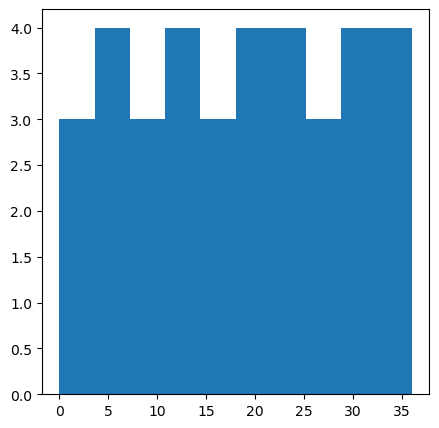

In [48]:
x = elev.flatten()
plt.hist(x);